### Loading Packages and Data

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 8)

#import xarray as xr
import warnings
warnings.filterwarnings('ignore')
from matplotlib.backends.backend_pdf import PdfPages

from db_queries import get_outputs as go
from db_queries import get_ids
from get_draws.api import get_draws

In [2]:
ls /mnt/team/simulation_science/priv/engineering/vivarium_nih_us_cvd/small_timing_runs/all_locations/count_data

deaths.csv                       risk_exposure_time.csv          ylds.csv
healthcare_visits.csv            sbp_medication_person_time.csv  ylls.csv
intervention_person_time.csv     state_person_time.csv
ldlc_medication_person_time.csv  transition_count.csv


In [3]:
sim_results_dir = '/mnt/team/simulation_science/priv/engineering/vivarium_nih_us_cvd/small_timing_runs/all_locations/count_data'

## Checking Stability of Risks over Time

In [4]:
state_person_time = pd.read_csv(sim_results_dir + '/state_person_time.csv')
person_time = state_person_time.loc[state_person_time['state'].isin(["acute_ischemic_stroke", "chronic_ischemic_stroke", "susceptible_to_ischemic_stroke"])].reset_index() 
person_time = person_time.rename(columns = {'value':'ptvalue'})
per_time_group = person_time.groupby(['age', 'sex', 'year','input_draw','scenario','location']).ptvalue.sum().reset_index()
per_time_group.head()

age     sex  year  input_draw  scenario    location      ptvalue
0  25_to_29  Female  2021          29  baseline     alabama  2359.589322
1  25_to_29  Female  2021          29  baseline      alaska  2331.991786
2  25_to_29  Female  2021          29  baseline  california  2535.676934
3  25_to_29  Female  2021          29  baseline     florida  2212.479124
4  25_to_29  Female  2021          29  baseline      kansas  2212.172485

### BMI

In [5]:
risk_exp = pd.read_csv(sim_results_dir + '/risk_exposure_time.csv')
risk_exp.head()

Unnamed: 0     sex  year                            risk  \
0           0  Female  2021  high_body_mass_index_in_adults   
1           1  Female  2021  high_body_mass_index_in_adults   
2           2  Female  2021  high_body_mass_index_in_adults   
3           3  Female  2021  high_body_mass_index_in_adults   
4           4  Female  2021  high_body_mass_index_in_adults   

              measure  input_draw       scenario       age         value  \
0  risk_exposure_time          29       baseline  25_to_29  64681.375652   
1  risk_exposure_time          29  lifestyle_100  25_to_29  65283.168359   
2  risk_exposure_time          29   outreach_100  25_to_29  64608.500365   
3  risk_exposure_time          29   polypill_100  25_to_29  64554.505415   
4  risk_exposure_time          29       baseline  30_to_34  68905.693706   

     location  
0  washington  
1  washington  
2  washington  
3  washington  
4  washington

In [6]:
bmi_exp = risk_exp.loc[risk_exp['risk']=='high_body_mass_index_in_adults']
bmi_exp.head()

Unnamed: 0     sex  year                            risk  \
0           0  Female  2021  high_body_mass_index_in_adults   
1           1  Female  2021  high_body_mass_index_in_adults   
2           2  Female  2021  high_body_mass_index_in_adults   
3           3  Female  2021  high_body_mass_index_in_adults   
4           4  Female  2021  high_body_mass_index_in_adults   

              measure  input_draw       scenario       age         value  \
0  risk_exposure_time          29       baseline  25_to_29  64681.375652   
1  risk_exposure_time          29  lifestyle_100  25_to_29  65283.168359   
2  risk_exposure_time          29   outreach_100  25_to_29  64608.500365   
3  risk_exposure_time          29   polypill_100  25_to_29  64554.505415   
4  risk_exposure_time          29       baseline  30_to_34  68905.693706   

     location  
0  washington  
1  washington  
2  washington  
3  washington  
4  washington

In [7]:
bmi_exp_rate = bmi_exp.groupby(['age','sex','year','input_draw','scenario','location']).value.sum().reset_index()
bmi_exp_rate = bmi_exp_rate.merge(per_time_group[['age','sex','year','input_draw','scenario','location','ptvalue']],on=['age','sex','year','input_draw','scenario','location'])
#bmi_exp_rate = pd.concat([bmi_exp_rate, per_time_group.ptvalue], axis=1)
bmi_exp_rate['bmi_rate'] = bmi_exp_rate['value'] / bmi_exp_rate['ptvalue']
bmi_exp_rate_summ = (bmi_exp_rate
                .groupby(['age', 'sex', 'year','scenario','location'])
                .bmi_rate.describe(percentiles=[.025,0.5, .975])
                .filter(['mean', '50%','2.5%', '97.5%'])
                .reset_index())
bmi_exp_rate_summ.head()

age     sex  year  scenario    location       mean        50%  \
0  25_to_29  Female  2021  baseline     alabama  30.764159  30.762335   
1  25_to_29  Female  2021  baseline      alaska  29.097522  29.140693   
2  25_to_29  Female  2021  baseline  california  28.342138  28.367597   
3  25_to_29  Female  2021  baseline     florida  29.160702  29.136332   
4  25_to_29  Female  2021  baseline      kansas  30.147548  30.040975   

        2.5%      97.5%  
0  30.283993  31.392083  
1  28.687189  29.343285  
2  28.068996  28.502484  
3  28.864239  29.643084  
4  29.832299  30.606193

In [8]:
%%capture

for sex in bmi_exp_rate_summ.sex.unique():
    for location in bmi_exp_rate_summ.location.unique():
        for age in bmi_exp_rate_summ.age.unique():
            plt.figure() 
            subdata = bmi_exp_rate_summ.loc[(bmi_exp_rate_summ.sex==sex) & (bmi_exp_rate_summ.location==location) & (bmi_exp_rate_summ.age==age) & (bmi_exp_rate_summ.scenario=='baseline')]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
            subdata = bmi_exp_rate_summ.loc[(bmi_exp_rate_summ.sex==sex) & (bmi_exp_rate_summ.location==location) & (bmi_exp_rate_summ.age==age) & (bmi_exp_rate_summ.scenario=='lifestyle_100')]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
            subdata = bmi_exp_rate_summ.loc[(bmi_exp_rate_summ.sex==sex) & (bmi_exp_rate_summ.location==location) & (bmi_exp_rate_summ.age==age) & (bmi_exp_rate_summ.scenario=='outreach_100')]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
            subdata = bmi_exp_rate_summ.loc[(bmi_exp_rate_summ.sex==sex) & (bmi_exp_rate_summ.location==location) & (bmi_exp_rate_summ.age==age) & (bmi_exp_rate_summ.scenario=='polypill_100')]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
            plt.legend(['Baseline','Baseline 95%','Lifestyle','Lifestyle 95%','Outreach','Outreach 95%','Polypill','Polypill 95%'])
            plt.title(f'BMI Exposure: {location} in {sex} {age}') 
            plt.xticks(rotation=90) 
            #plt.ylim(20,33)
            plt.grid()
            plt.savefig('bmi_exp_07_31_2023.pdf', format='pdf')

As expected, lifestyle is the only scenario with a real change in BMI. This is good as it is the only one that directly affects BMI and nothing is correlated yet! 

### SBP 

In [9]:
sbp_exp = risk_exp.loc[risk_exp['risk']=='high_systolic_blood_pressure']
sbp_exp_rate = sbp_exp.groupby(['age','sex','year','input_draw','scenario','location']).value.sum().reset_index()
sbp_exp_rate = pd.concat([sbp_exp_rate, per_time_group.ptvalue], axis=1)
sbp_exp_rate['sbp_rate'] = sbp_exp_rate['value'] / sbp_exp_rate['ptvalue']
sbp_exp_rate_summ = (sbp_exp_rate
                .groupby(['age', 'sex', 'year','scenario','location'])
                .sbp_rate.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())
sbp_exp_rate_summ.head()

age     sex  year  scenario    location        mean        2.5%  \
0  25_to_29  Female  2021  baseline     alabama  110.151473  108.014041   
1  25_to_29  Female  2021  baseline      alaska  109.270249  107.308177   
2  25_to_29  Female  2021  baseline  california  108.814954  107.601020   
3  25_to_29  Female  2021  baseline     florida  109.864033  108.286834   
4  25_to_29  Female  2021  baseline      kansas  108.986761  107.039820   

        97.5%  
0  112.703179  
1  111.437316  
2  109.770018  
3  111.621136  
4  110.250072

In [10]:
%%capture
for location in sbp_exp_rate_summ.location.unique():
    for sex in sbp_exp_rate_summ.sex.unique():
        for age in sbp_exp_rate_summ.age.unique():
            plt.figure() 
            subdata = sbp_exp_rate_summ.loc[(sbp_exp_rate_summ.location==location) & (sbp_exp_rate_summ.sex==sex) & (sbp_exp_rate_summ.age==age) & (sbp_exp_rate_summ.scenario=='baseline')]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
            subdata = sbp_exp_rate_summ.loc[(sbp_exp_rate_summ.location==location) & (sbp_exp_rate_summ.sex==sex) & (sbp_exp_rate_summ.age==age) & (sbp_exp_rate_summ.scenario=='lifestyle_100')]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
            subdata = sbp_exp_rate_summ.loc[(sbp_exp_rate_summ.location==location) & (sbp_exp_rate_summ.sex==sex) & (sbp_exp_rate_summ.age==age) & (sbp_exp_rate_summ.scenario=='outreach_100')]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
            subdata = sbp_exp_rate_summ.loc[(sbp_exp_rate_summ.location==location) & (sbp_exp_rate_summ.sex==sex) & (sbp_exp_rate_summ.age==age) & (sbp_exp_rate_summ.scenario=='polypill_100')]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
            plt.legend(['Baseline','Baseline 95%','Lifestyle','Lifestyle 95%','Outreach','Outreach 95%','Polypill','Polypill 95%'])
            plt.title(f'SBP Exposure: {location} in {sex} {age}') 
            plt.xticks(rotation=90) 
            #plt.ylim(0,100000)
            plt.grid()
            plt.savefig('sbp_exp_07_31_2023.pdf', format='pdf')

Polypill and outreach have a visible impact on SBP as expected. Lifestyle has a slight effect as expected. 

### LDL-C

In [11]:
ldl_exp = risk_exp.loc[risk_exp['risk']=='high_ldl_cholesterol']
ldl_exp_rate = ldl_exp.groupby(['age','sex','year','input_draw','scenario','location']).value.sum().reset_index()
ldl_exp_rate = pd.concat([ldl_exp_rate, per_time_group.ptvalue], axis=1)
ldl_exp_rate['ldl_rate'] = ldl_exp_rate['value'] / ldl_exp_rate['ptvalue']
ldl_exp_rate_summ = (ldl_exp_rate
                .groupby(['age', 'sex', 'year','scenario','location'])
                .ldl_rate.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())
ldl_exp_rate_summ.head()

age     sex  year  scenario    location      mean      2.5%     97.5%
0  25_to_29  Female  2021  baseline     alabama  2.640172  2.554664  2.801066
1  25_to_29  Female  2021  baseline      alaska  2.666638  2.526577  2.836781
2  25_to_29  Female  2021  baseline  california  2.618565  2.460629  2.716214
3  25_to_29  Female  2021  baseline     florida  2.664315  2.568452  2.791508
4  25_to_29  Female  2021  baseline      kansas  2.653529  2.489899  2.845253

In [12]:
%%capture
for location in ldl_exp_rate_summ.location.unique():
    for sex in ldl_exp_rate_summ.sex.unique():
        for age in ldl_exp_rate_summ.age.unique():
            plt.figure() 
            subdata = ldl_exp_rate_summ.loc[(ldl_exp_rate_summ.location==location) & (ldl_exp_rate_summ.sex==sex) & (ldl_exp_rate_summ.age==age) & (ldl_exp_rate_summ.scenario=='baseline')]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
            subdata = ldl_exp_rate_summ.loc[(ldl_exp_rate_summ.location==location) & (ldl_exp_rate_summ.sex==sex) & (ldl_exp_rate_summ.age==age) & (ldl_exp_rate_summ.scenario=='lifestyle_100')]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
            subdata = ldl_exp_rate_summ.loc[(ldl_exp_rate_summ.location==location) & (ldl_exp_rate_summ.sex==sex) & (ldl_exp_rate_summ.age==age) & (ldl_exp_rate_summ.scenario=='outreach_100')]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
            subdata = ldl_exp_rate_summ.loc[(ldl_exp_rate_summ.location==location) & (ldl_exp_rate_summ.sex==sex) & (ldl_exp_rate_summ.age==age) & (ldl_exp_rate_summ.scenario=='polypill_100')]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
            plt.legend(['Baseline','Baseline 95%','Lifestyle','Lifestyle 95%','Outreach','Outreach 95%','Polypill','Polypill 95%'])
            plt.title(f'LDL-C Exposure: {location} in {sex} {age}') 
            plt.xticks(rotation=90) 
            #plt.ylim(0,100000)
            plt.grid()
            plt.savefig('ldl_exp_07_31_2023.pdf', format='pdf')

Outreach has the biggest impact. This makes sense with the not yet fixed issues of LDL meds in older adults. Should recheck once those are fixed. 

### FPG

In [13]:
fpg_exp = risk_exp.loc[risk_exp['risk']=='high_fasting_plasma_glucose']
fpg_exp_rate = fpg_exp.groupby(['age','sex','year','input_draw','scenario','location']).value.sum().reset_index()
fpg_exp_rate = pd.concat([fpg_exp_rate, per_time_group.ptvalue], axis=1)
fpg_exp_rate['fpg_rate'] = fpg_exp_rate['value'] / fpg_exp_rate['ptvalue']
fpg_exp_rate_summ = (fpg_exp_rate
                .groupby(['age', 'sex', 'year','scenario','location'])
                .fpg_rate.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())
fpg_exp_rate_summ.head()

age     sex  year  scenario    location      mean      2.5%     97.5%
0  25_to_29  Female  2021  baseline     alabama  5.350057  4.847449  6.247637
1  25_to_29  Female  2021  baseline      alaska  5.158030  4.687708  5.589098
2  25_to_29  Female  2021  baseline  california  5.252319  4.577589  5.873646
3  25_to_29  Female  2021  baseline     florida  5.454713  4.899310  5.936382
4  25_to_29  Female  2021  baseline      kansas  5.397651  4.618408  6.131524

In [14]:
%%capture
for location in fpg_exp_rate_summ.location.unique():
    for sex in fpg_exp_rate_summ.sex.unique():
        for age in fpg_exp_rate_summ.age.unique():
            plt.figure() 
            subdata = fpg_exp_rate_summ.loc[(fpg_exp_rate_summ.location==location) & (fpg_exp_rate_summ.sex==sex) & (fpg_exp_rate_summ.age==age) & (fpg_exp_rate_summ.scenario=='baseline')]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
            subdata = fpg_exp_rate_summ.loc[(fpg_exp_rate_summ.location==location) & (fpg_exp_rate_summ.sex==sex) & (fpg_exp_rate_summ.age==age) & (fpg_exp_rate_summ.scenario=='lifestyle_100')]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
            subdata = fpg_exp_rate_summ.loc[(fpg_exp_rate_summ.location==location) & (fpg_exp_rate_summ.sex==sex) & (fpg_exp_rate_summ.age==age) & (fpg_exp_rate_summ.scenario=='outreach_100')]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
            subdata = fpg_exp_rate_summ.loc[(fpg_exp_rate_summ.location==location) & (fpg_exp_rate_summ.sex==sex) & (fpg_exp_rate_summ.age==age) & (fpg_exp_rate_summ.scenario=='polypill_100')]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
            plt.legend(['Baseline','Baseline 95%','Lifestyle','Lifestyle 95%','Outreach','Outreach 95%','Polypill','Polypill 95%'])
            plt.title(f'FPG Exposure: {location} in {sex} {age}') 
            plt.xticks(rotation=90) 
            #plt.ylim(0,100000)
            plt.grid()
            plt.savefig('fpg_exp_07_31_2023.pdf', format='pdf')

Very modest improvments for lifestyle intervention. 

## Comparison to Artifacts

In [15]:
ls /mnt/team/simulation_science/costeffectiveness/artifacts/vivarium_nih_us_cvd/51-locations/v1-20230613

a.hdf                     logs/               oklahoma.hdf
alabama.hdf               louisiana.hdf       oregon.hdf
alaska.hdf                maine.hdf           paf-calculations/
arizona.hdf               maryland.hdf        pennsylvania.hdf
arkansas.hdf              massachusetts.hdf   rhode_island.hdf
california.hdf            michigan.hdf        south_carolina.hdf
colorado.hdf              minnesota.hdf       south_dakota.hdf
connecticut.hdf           mississippi.hdf     south_dakotatennessee.hdf
delaware.hdf              missouri.hdf        tennessee.hdf
district_of_columbia.hdf  montana.hdf         texas.hdf
florida.hdf               nebraska.hdf        utah.hdf
georgia.hdf               nevada.hdf          vermont.hdf
hawaii.hdf                new_hampshire.hdf   virginia.hdf
idaho.hdf                 new_jersey.hdf      washington.hdf
illinois.hdf              new_mexico.hdf      west_virginia.hdf
indiana.hdf               new_york.hdf        wisconsin.hdf
iowa.hdf             

In [16]:
from vivarium import Artifact

#explore the artifact data (note age groups)
art = Artifact('/mnt/team/simulation_science/costeffectiveness/artifacts/vivarium_nih_us_cvd/51-locations/alabama.hdf', filter_terms=['year_start == 2019', 'age_start >=  25'])

In [17]:
#art.keys

In [18]:
locations = risk_exp.location.unique()

In [19]:
def load_artifact_data(word:str, cause:str, measure:str):
    master_art_data = pd.DataFrame()
    for i in locations: #in case there are other countries
        
        # grab main artifact object
        art = Artifact('/mnt/team/simulation_science/costeffectiveness/artifacts/vivarium_nih_us_cvd/51-locations/v1-20230613/' + i + '.hdf', 
                   filter_terms=['year_start == 2019', 'age_start >=  25']) # << MIGHT WANT TO CHANGE THESE TERMS
        
        # load requested measure
        data = art.load(word + '.' + cause + '.' + measure)
        #data = data[['draw_29','draw_232','draw_357','draw_394','draw_602','draw_629','draw_650','draw_680','draw_829','draw_949']]

        # collapse to desired percentiles
        data = data.apply(pd.DataFrame.describe, percentiles=[0.025, 0.5, 0.975], axis=1).filter(['mean', '50%', '2.5%', '97.5%']).reset_index()
        
        # formatting (may want to format age as well)
        data['location'] = i#.capitalize()
        data['measure'] = measure
        #data['sex'] = np.where(data['sex'] == 'Female', 'female', 'male')
    
   
        master_art_data = master_art_data.append(data)
        
    return master_art_data

### BMI

In [20]:
bmi_art = load_artifact_data('risk_factor', 'high_body_mass_index_in_adults', 'exposure')
bmi_art['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(bmi_art.age_start,bmi_art.age_end)]
bmi_art.head()

sex  age_start  age_end  year_start  year_end   parameter       mean  \
0  Female       25.0     30.0        2019      2020  continuous  29.033412   
1  Female       30.0     35.0        2019      2020  continuous  29.632278   
2  Female       35.0     40.0        2019      2020  continuous  29.949943   
3  Female       40.0     45.0        2019      2020  continuous  30.112389   
4  Female       45.0     50.0        2019      2020  continuous  30.238533   

         50%       2.5%      97.5%    location   measure age_group  
0  29.033224  28.757366  29.300440  washington  exposure  25_to_29  
1  29.631791  29.332102  29.905088  washington  exposure  30_to_34  
2  29.951277  29.684073  30.227876  washington  exposure  35_to_39  
3  30.112918  29.850097  30.399662  washington  exposure  40_to_44  
4  30.235057  29.936267  30.522230  washington  exposure  45_to_49

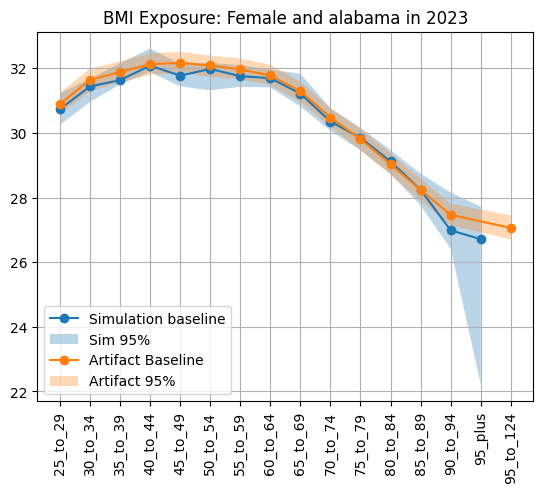

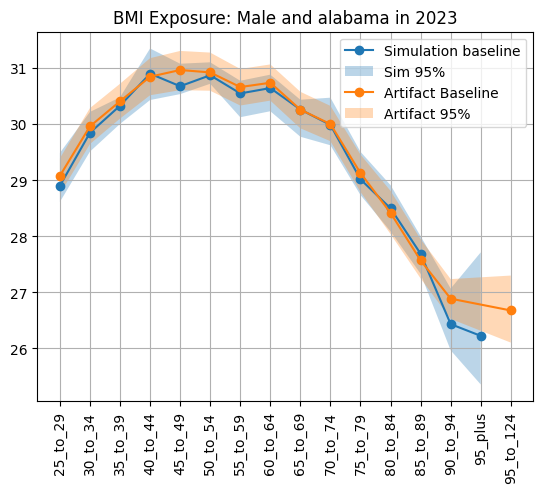

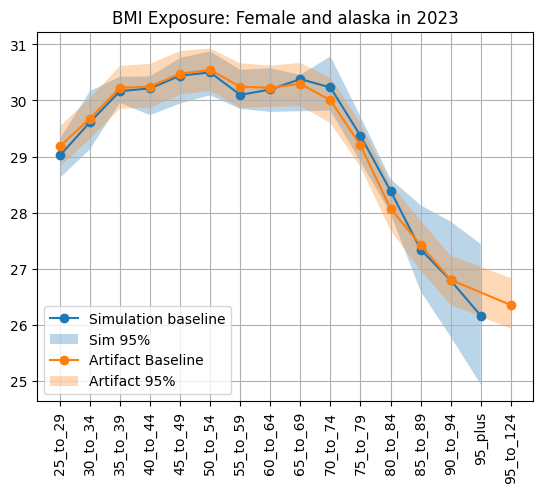

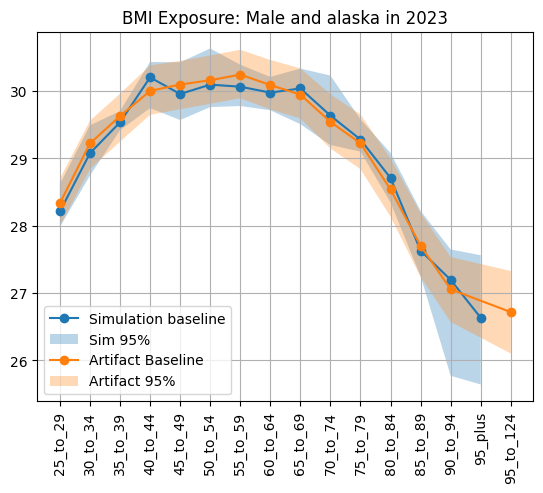

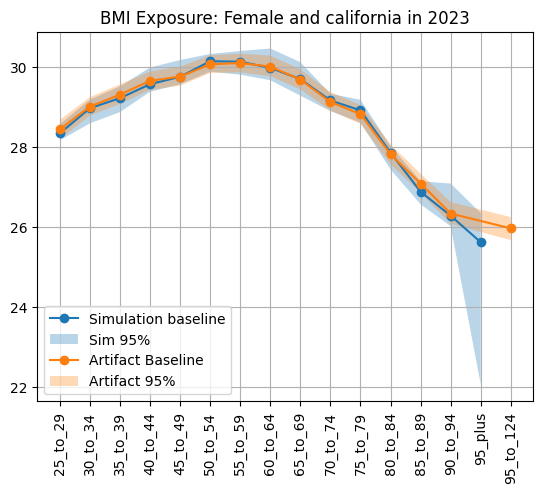

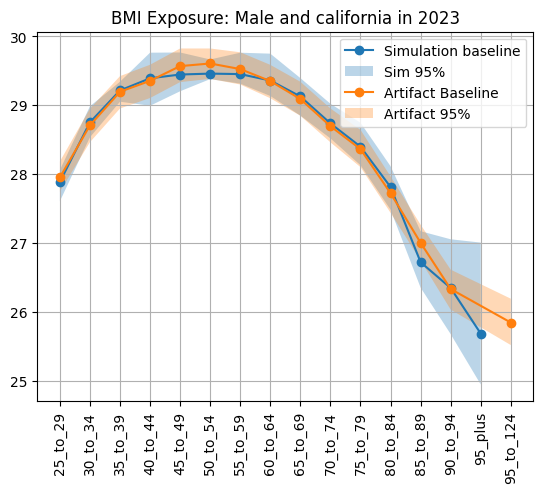

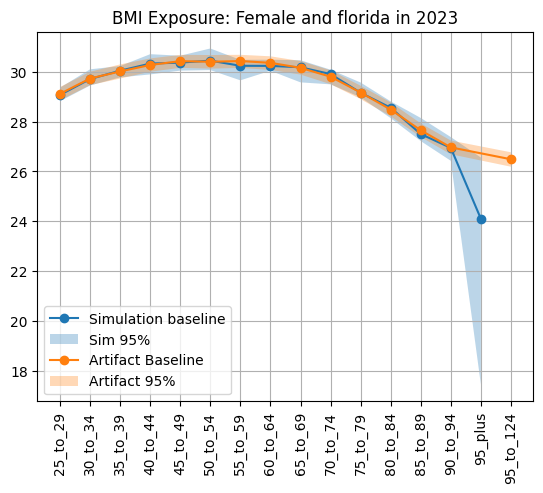

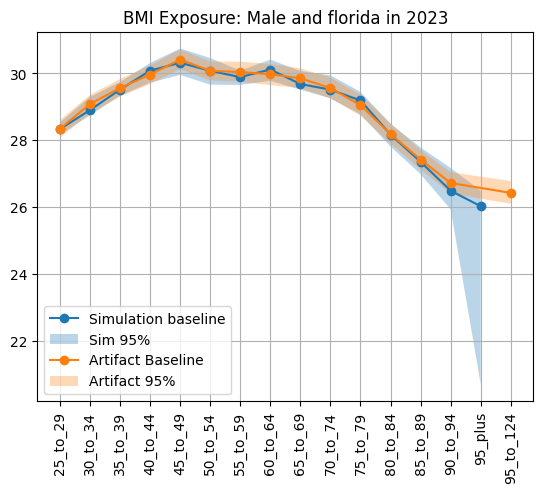

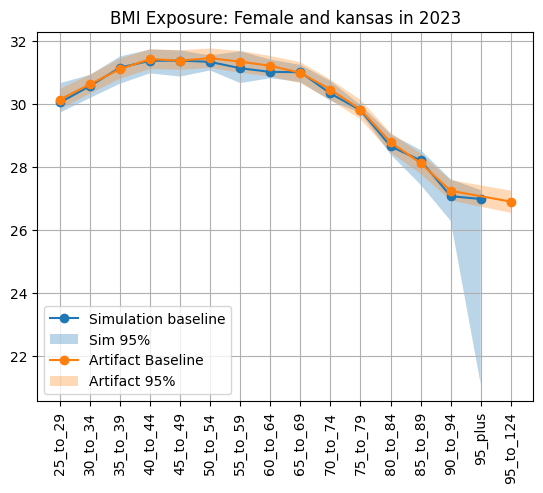

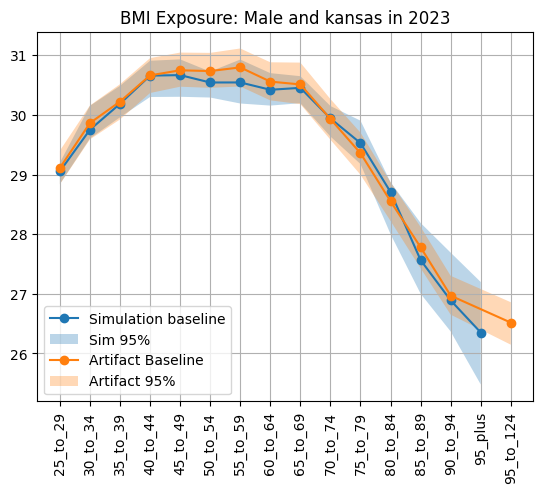

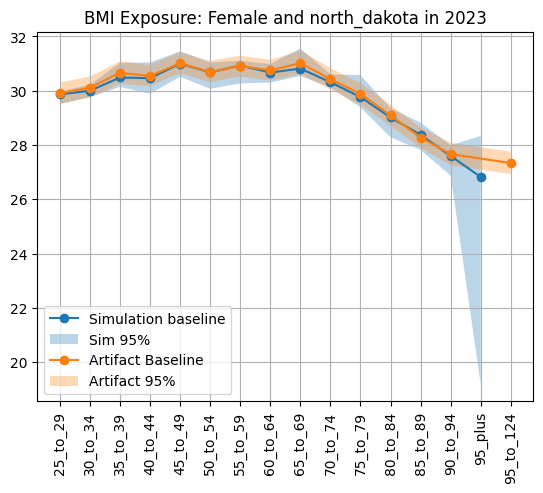

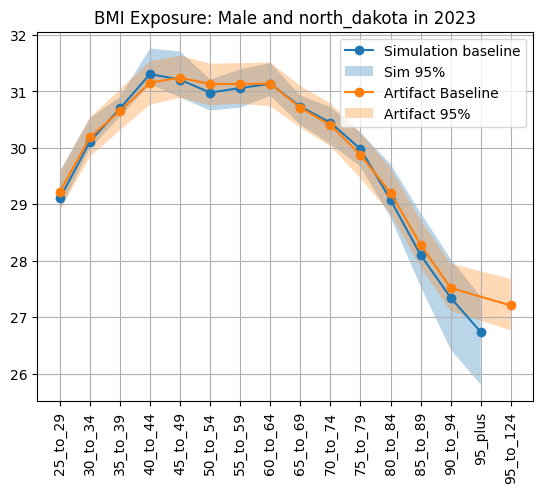

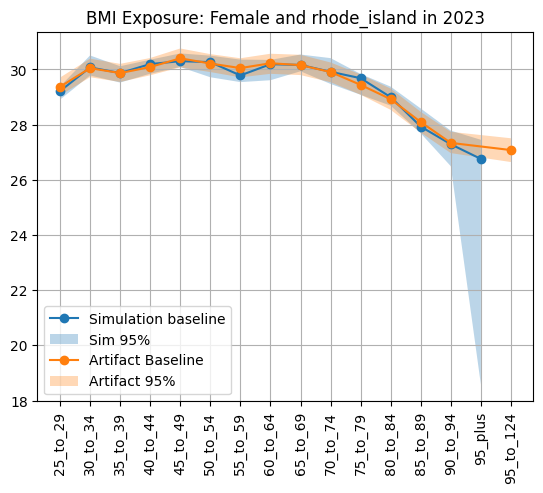

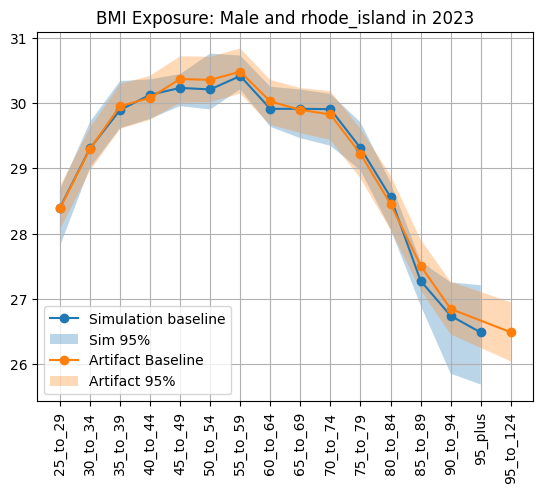

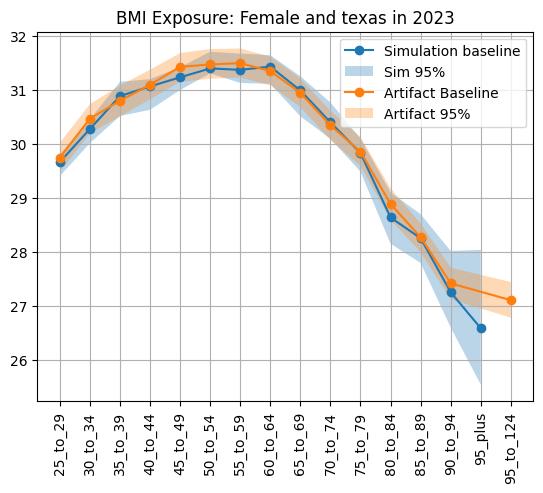

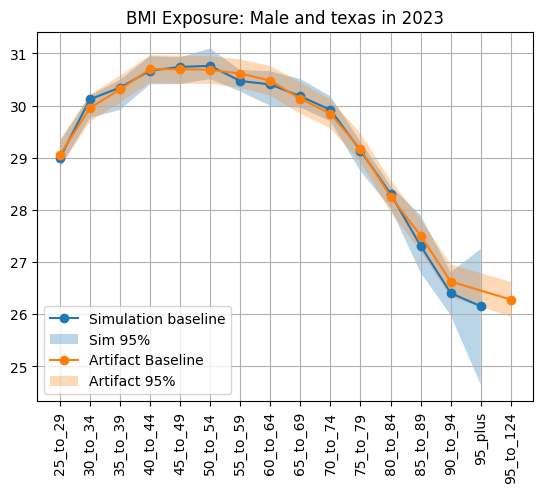

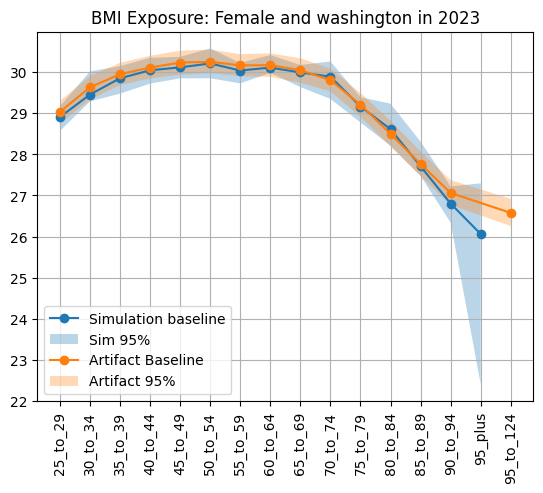

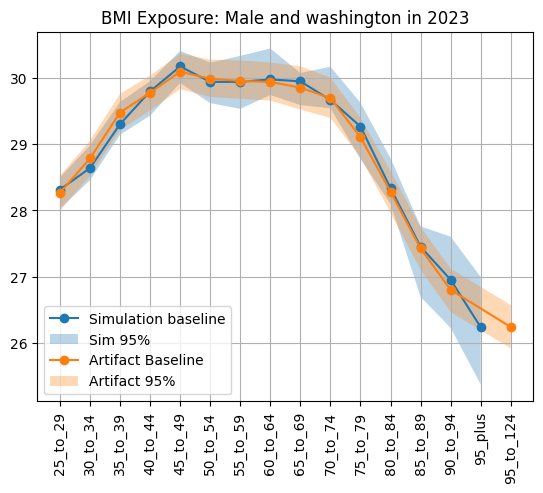

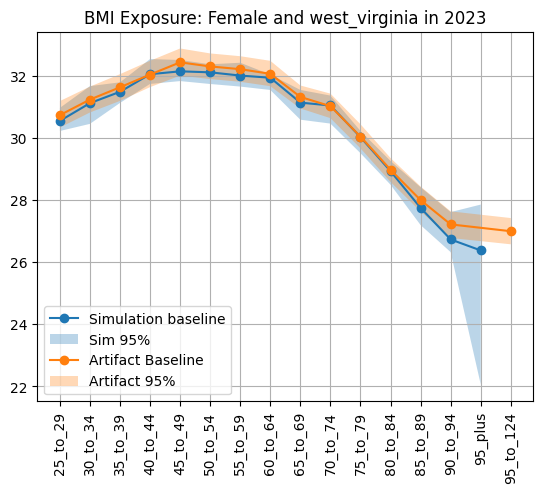

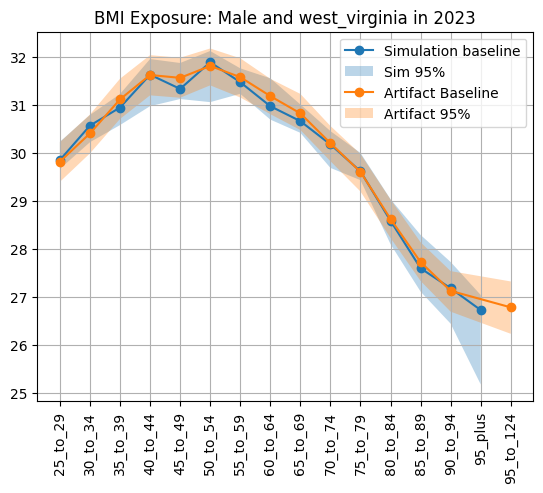

In [21]:
for location in bmi_exp_rate_summ.location.unique():
    for sex in bmi_exp_rate_summ.sex.unique():
        plt.figure() 
        subdata = bmi_exp_rate_summ.loc[(bmi_exp_rate_summ.location==location) & (bmi_exp_rate_summ.sex==sex) & (bmi_exp_rate_summ.year==2023) & (bmi_exp_rate_summ.scenario == 'baseline')]
        plt.plot(subdata['age'], subdata['50%'], marker='o')
        plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        subdata2 = bmi_art.loc[(bmi_art.location==location) & (bmi_art.sex==sex) & (bmi_art.year_end==2020)]
        plt.plot(subdata2['age_group'], subdata2['50%'], marker='o')
        plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
        plt.title(f'BMI Exposure: {sex} and {location} in 2023') 
        plt.xticks(rotation=90) 
        #plt.ylim(0,100000)
        plt.grid()
        plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

### SBP

In [22]:
sbp_art = load_artifact_data('risk_factor', 'high_systolic_blood_pressure', 'exposure')
sbp_art['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(sbp_art.age_start,sbp_art.age_end)]
sbp_art.head()

sex  age_start  age_end  year_start  year_end   parameter        mean  \
0  Female       25.0     30.0        2019      2020  continuous  109.038118   
1  Female       30.0     35.0        2019      2020  continuous  111.225071   
2  Female       35.0     40.0        2019      2020  continuous  113.783436   
3  Female       40.0     45.0        2019      2020  continuous  115.639212   
4  Female       45.0     50.0        2019      2020  continuous  118.694697   

          50%        2.5%       97.5%    location   measure age_group  
0  109.062796  106.405986  111.725097  washington  exposure  25_to_29  
1  111.256994  108.811490  113.590849  washington  exposure  30_to_34  
2  113.782741  111.085901  116.355446  washington  exposure  35_to_39  
3  115.571440  113.099469  118.525573  washington  exposure  40_to_44  
4  118.645973  116.152041  121.444385  washington  exposure  45_to_49

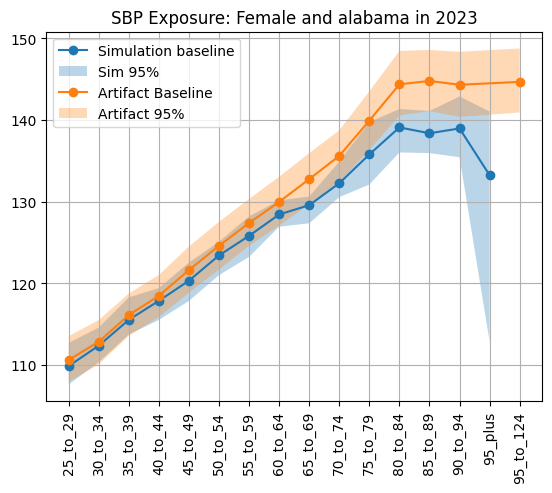

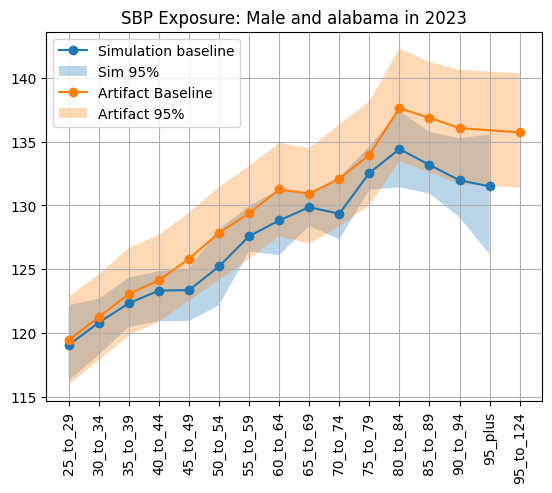

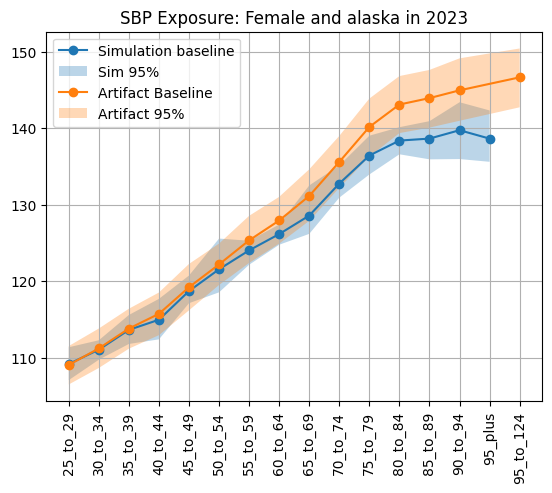

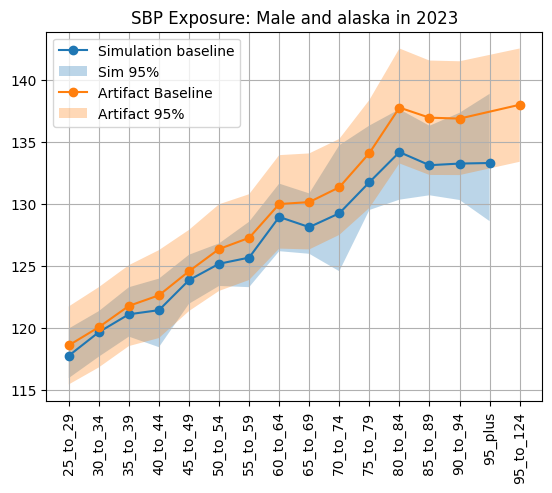

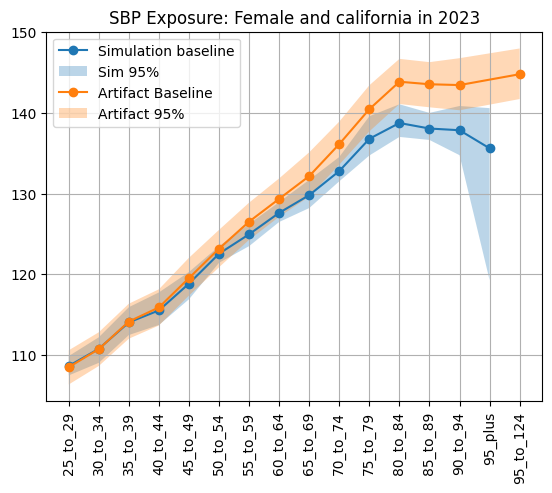

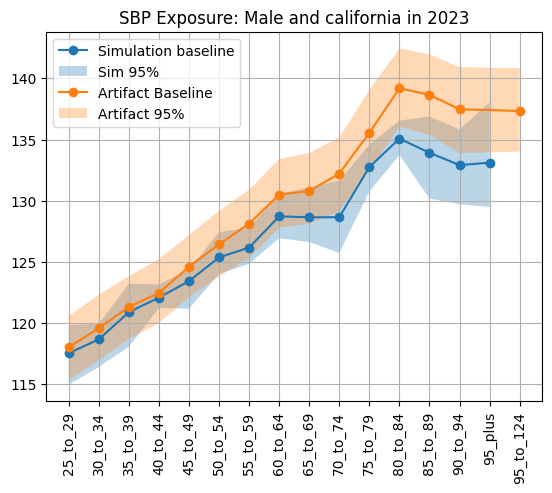

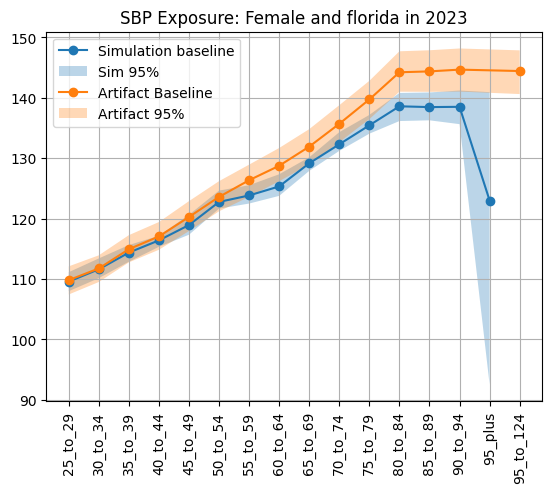

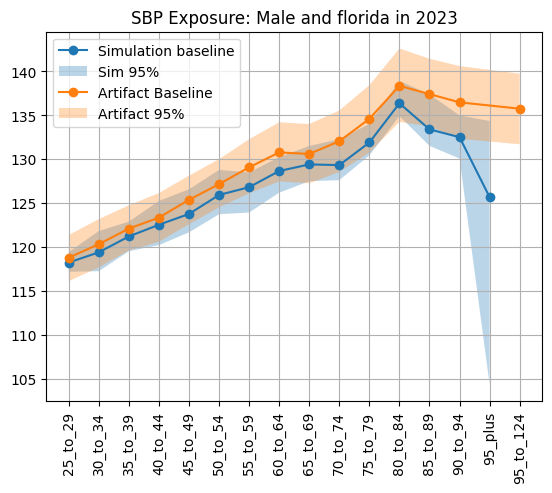

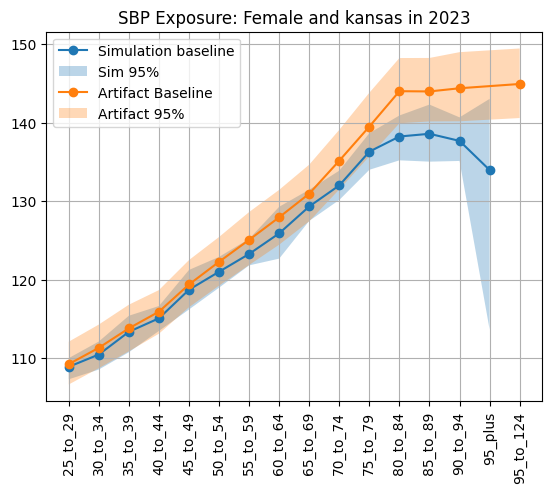

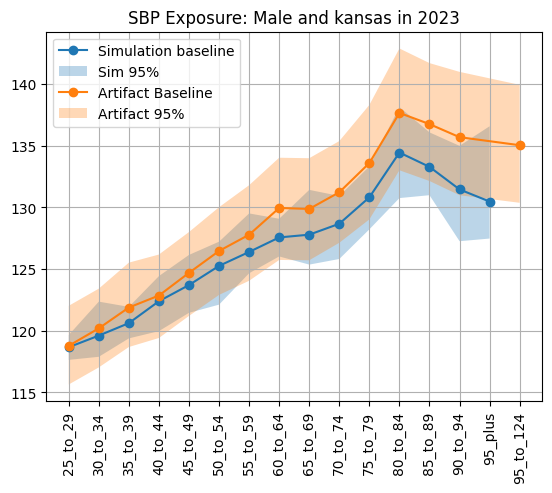

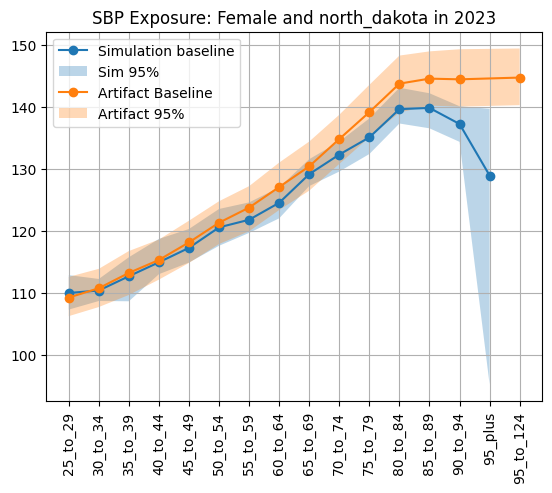

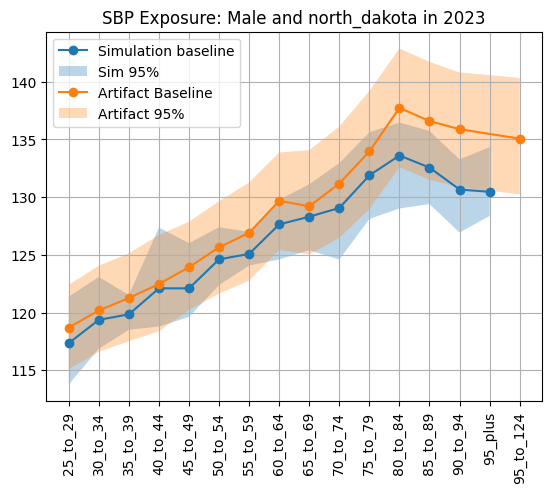

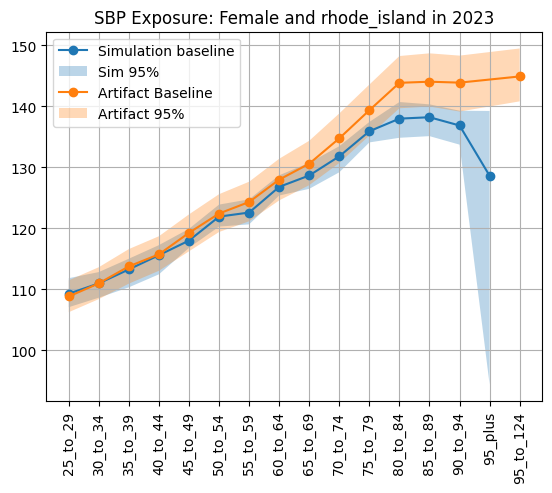

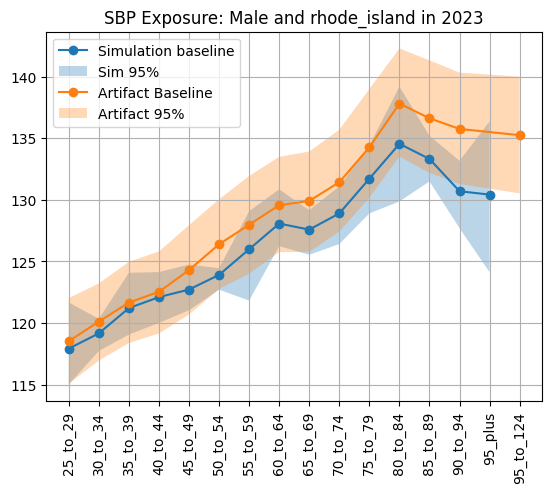

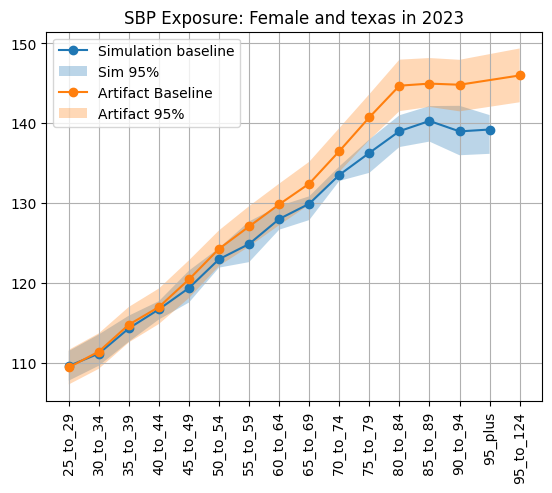

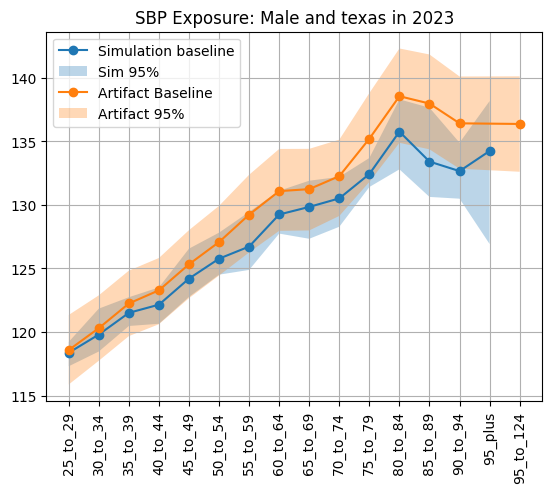

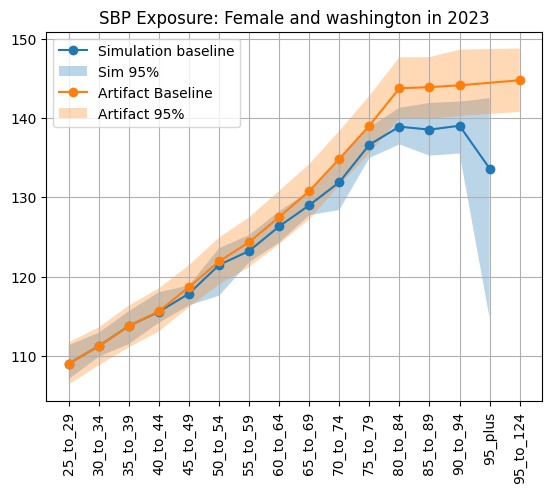

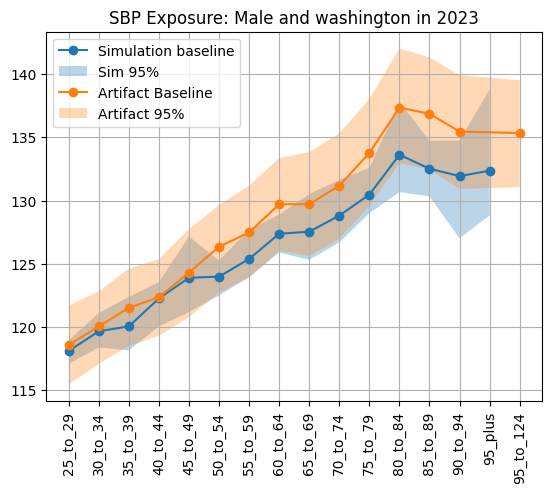

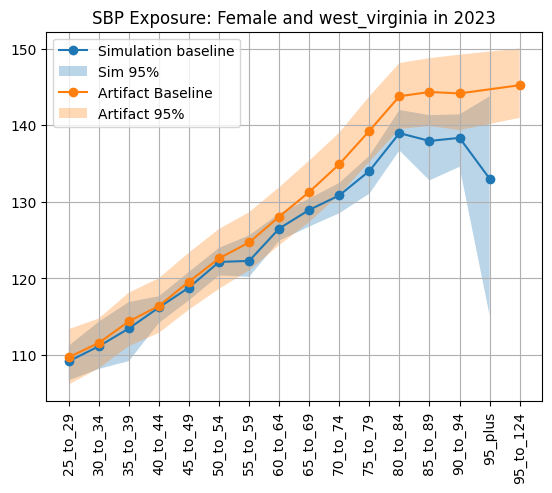

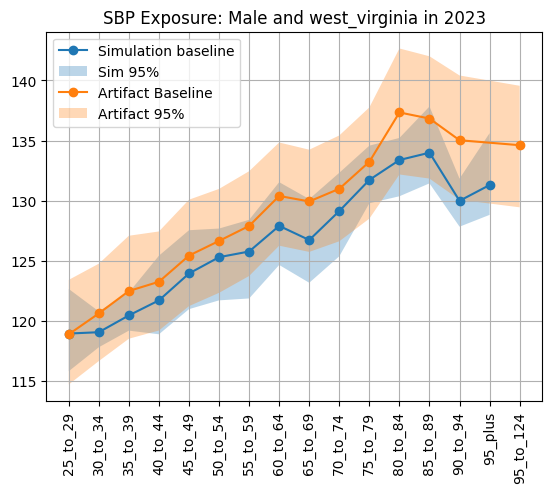

In [23]:
#Can we stratify by medication coverage? 

for location in sbp_exp_rate_summ.location.unique():
    for sex in sbp_exp_rate_summ.sex.unique():
        plt.figure() 
        subdata = sbp_exp_rate_summ.loc[(sbp_exp_rate_summ.location==location) & (sbp_exp_rate_summ.sex==sex) & (sbp_exp_rate_summ.year==2023) & (sbp_exp_rate_summ.scenario == 'baseline')]
        plt.plot(subdata['age'], subdata['mean'], marker='o')
        plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        subdata2 = sbp_art.loc[(sbp_art.location==location) & (sbp_art.sex==sex) & (sbp_art.year_end==2020)]
        plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
        plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
        plt.title(f'SBP Exposure: {sex} and {location} in 2023')
        plt.xticks(rotation=90) 
        #plt.ylim(0,100000)
        plt.grid()
        plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

### LDL-C

In [24]:
ldl_art = load_artifact_data('risk_factor', 'high_ldl_cholesterol', 'exposure')
ldl_art['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(ldl_art.age_start,ldl_art.age_end)]
ldl_art.head()

sex  age_start  age_end  year_start  year_end   parameter      mean  \
0  Female       25.0     30.0        2019      2020  continuous  2.653726   
1  Female       30.0     35.0        2019      2020  continuous  2.722218   
2  Female       35.0     40.0        2019      2020  continuous  2.845212   
3  Female       40.0     45.0        2019      2020  continuous  2.886024   
4  Female       45.0     50.0        2019      2020  continuous  3.017583   

        50%      2.5%     97.5%    location   measure age_group  
0  2.652674  2.501467  2.832722  washington  exposure  25_to_29  
1  2.720300  2.564508  2.893812  washington  exposure  30_to_34  
2  2.846297  2.685848  3.008155  washington  exposure  35_to_39  
3  2.886978  2.722389  3.045544  washington  exposure  40_to_44  
4  3.018424  2.840927  3.188939  washington  exposure  45_to_49

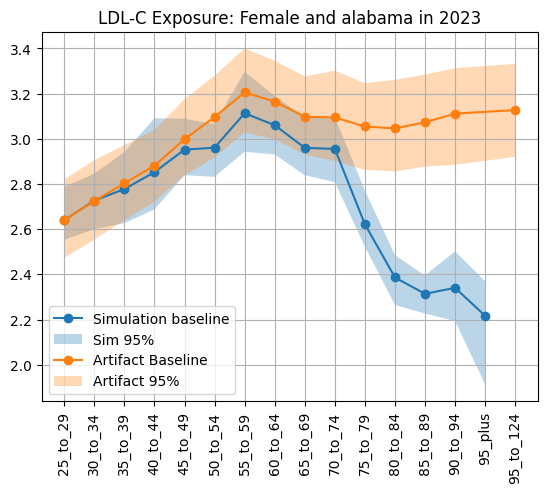

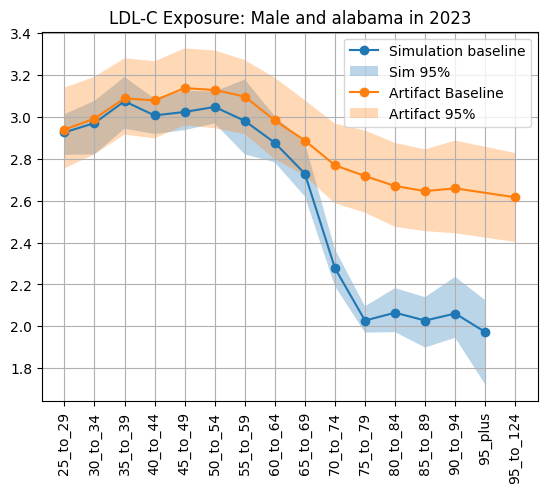

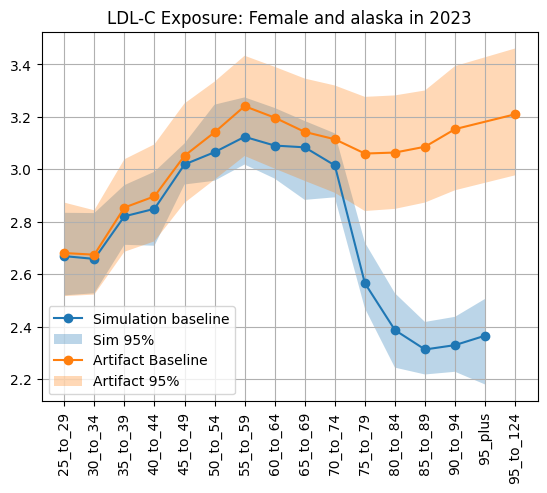

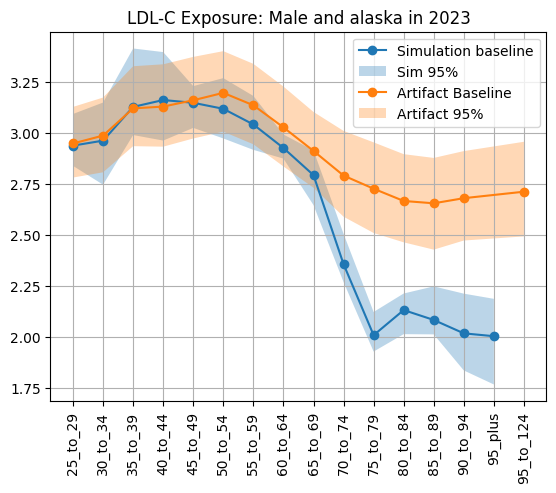

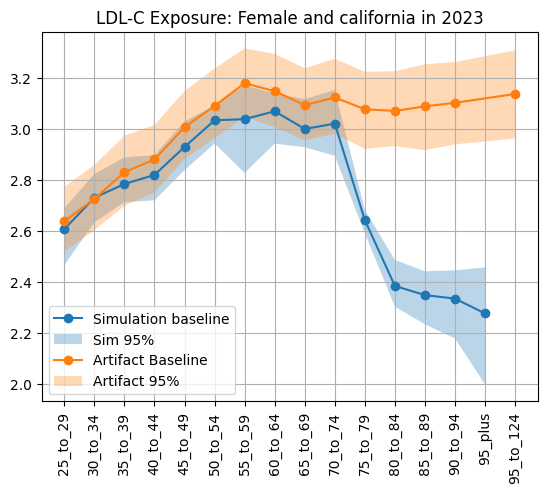

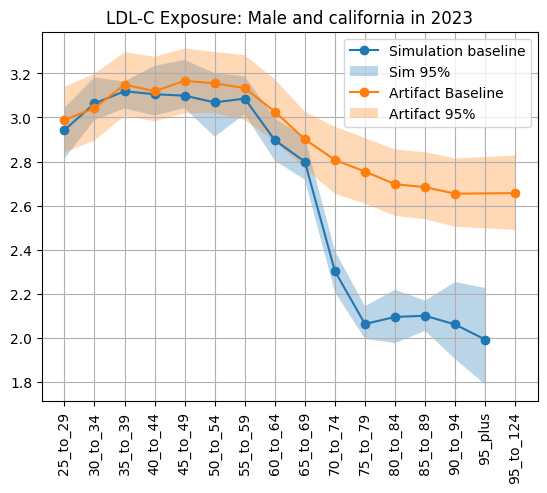

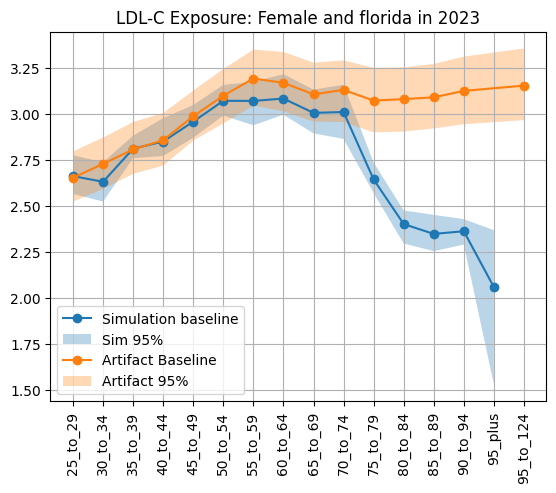

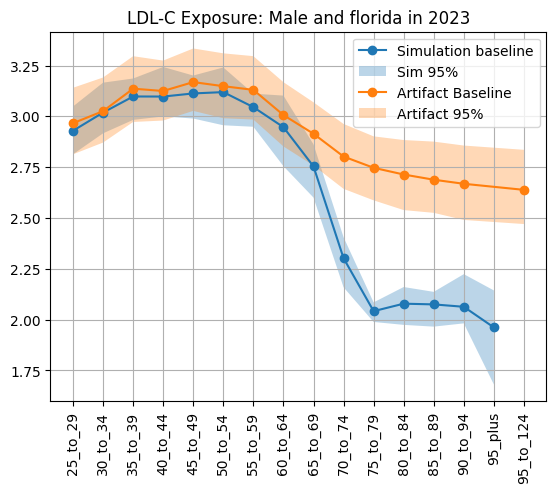

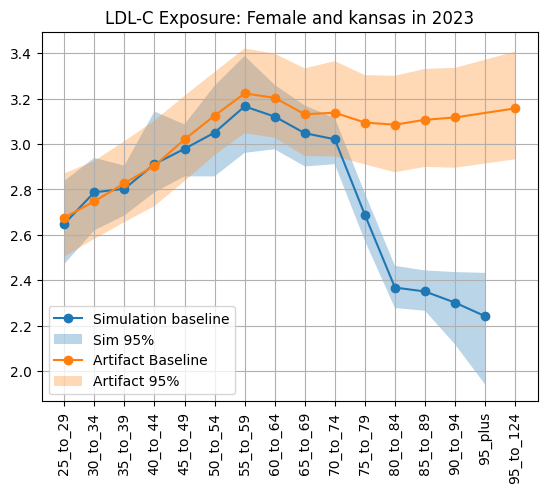

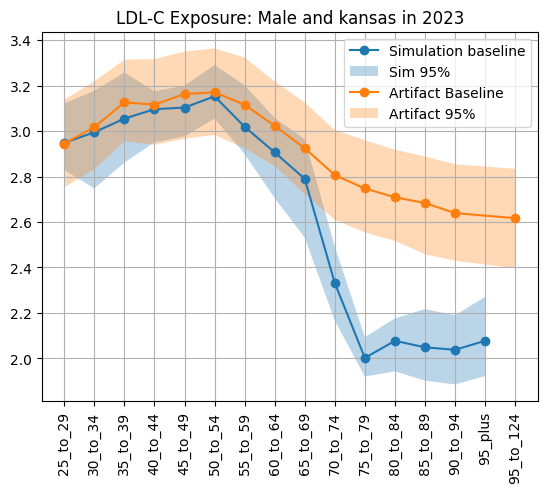

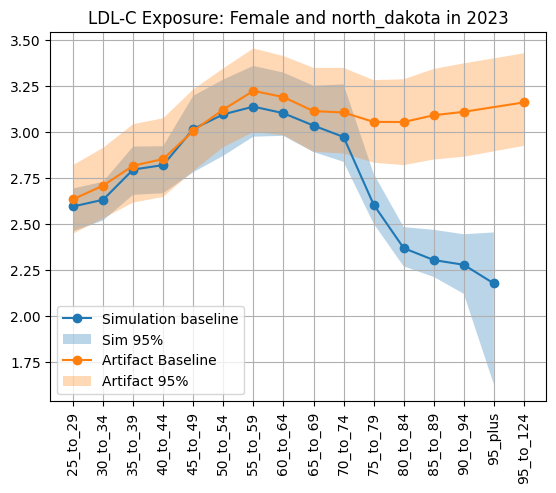

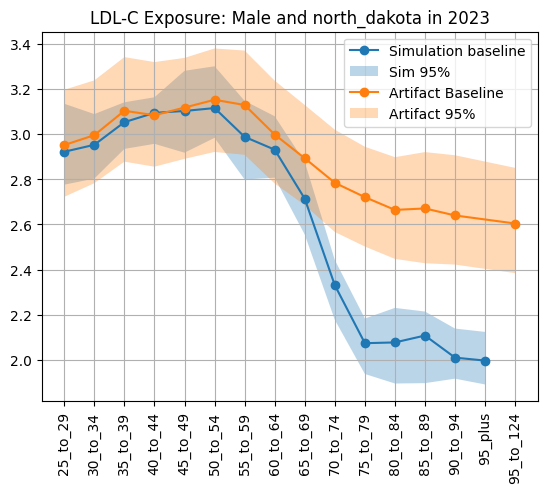

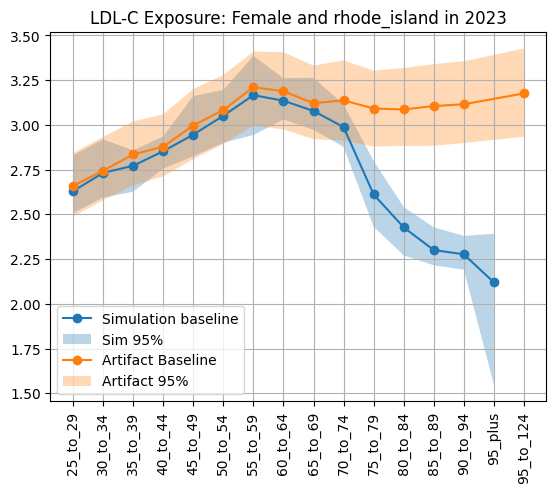

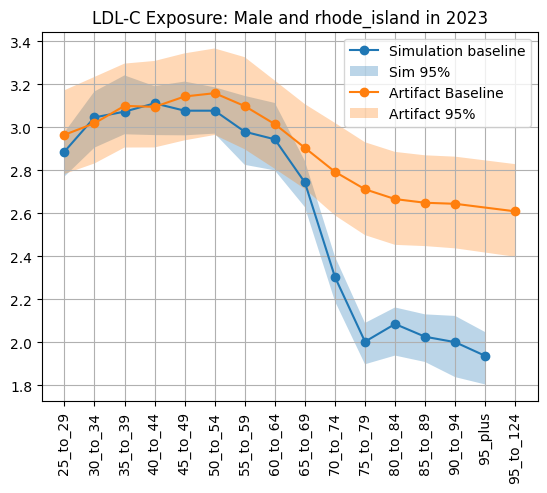

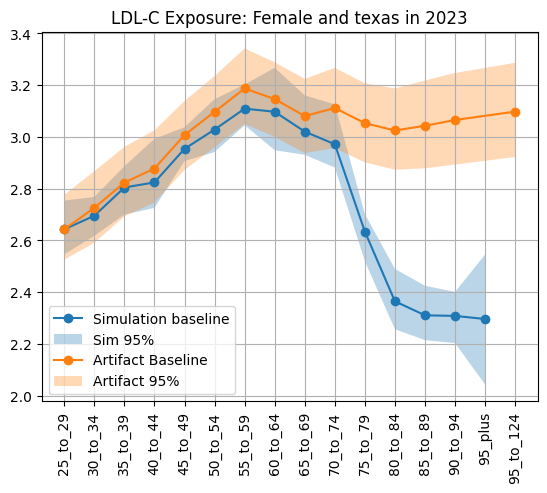

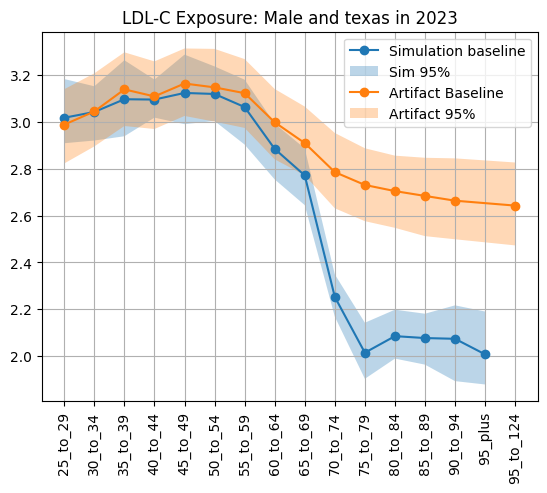

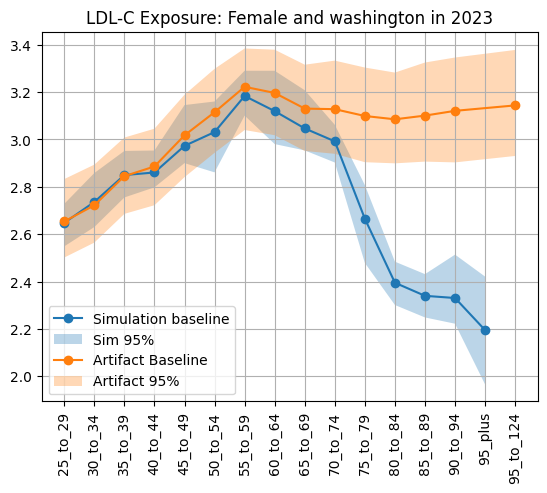

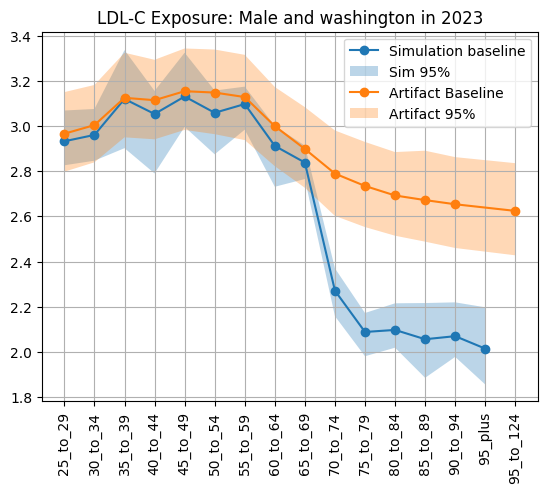

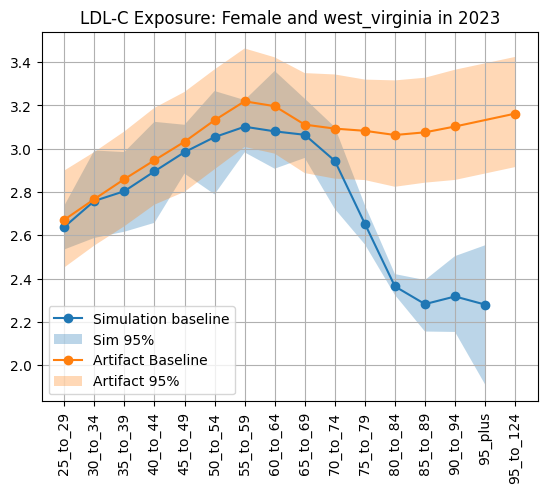

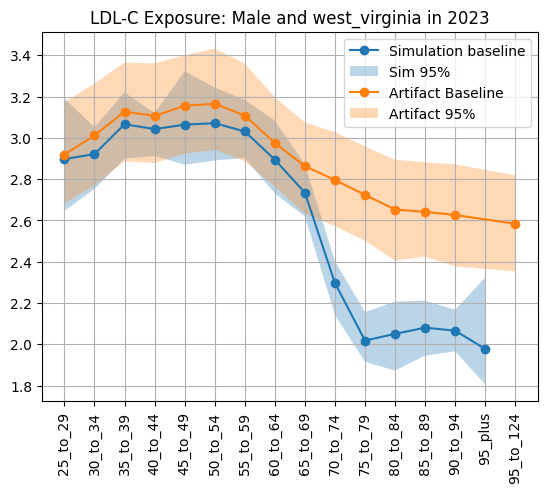

In [25]:
for location in ldl_exp_rate_summ.location.unique():
    for sex in ldl_exp_rate_summ.sex.unique():
        plt.figure() 
        subdata = ldl_exp_rate_summ.loc[(ldl_exp_rate_summ.location==location) & (ldl_exp_rate_summ.sex==sex) & (ldl_exp_rate_summ.year==2023) & (ldl_exp_rate_summ.scenario == 'baseline')]
        plt.plot(subdata['age'], subdata['mean'], marker='o')
        plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        subdata2 = ldl_art.loc[(ldl_art.location==location) & (ldl_art.sex==sex) & (ldl_art.year_end==2020)]
        plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
        plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
        plt.title(f'LDL-C Exposure: {sex} and {location} in 2023') 
        plt.xticks(rotation=90) 
        #plt.ylim(0,100000)
        plt.grid()
        plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

### FPG

In [26]:
fpg_art = load_artifact_data('risk_factor', 'high_fasting_plasma_glucose', 'exposure')
fpg_art['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(fpg_art.age_start,fpg_art.age_end)]
fpg_art.head()

sex  age_start  age_end  year_start  year_end   parameter      mean  \
0  Female       25.0     30.0        2019      2020  continuous  5.269120   
1  Female       30.0     35.0        2019      2020  continuous  5.436337   
2  Female       35.0     40.0        2019      2020  continuous  5.519157   
3  Female       40.0     45.0        2019      2020  continuous  5.593661   
4  Female       45.0     50.0        2019      2020  continuous  5.732924   

        50%      2.5%     97.5%    location   measure age_group  
0  5.252123  4.547909  6.017223  washington  exposure  25_to_29  
1  5.431789  4.784969  6.196334  washington  exposure  30_to_34  
2  5.495740  4.721254  6.442020  washington  exposure  35_to_39  
3  5.578179  4.811193  6.427358  washington  exposure  40_to_44  
4  5.725901  4.948982  6.575077  washington  exposure  45_to_49

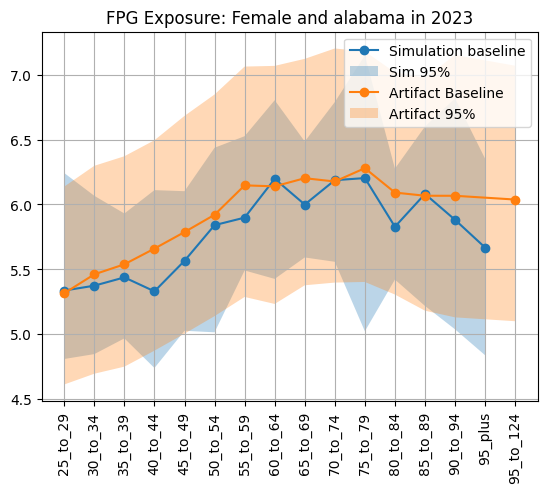

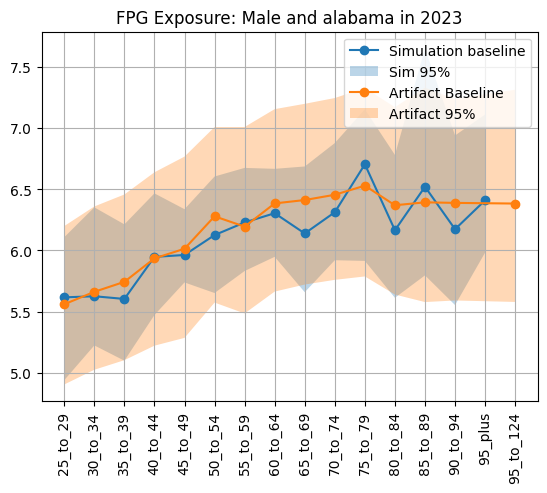

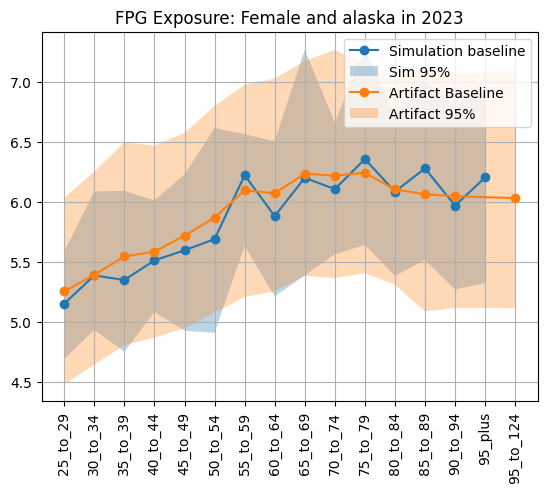

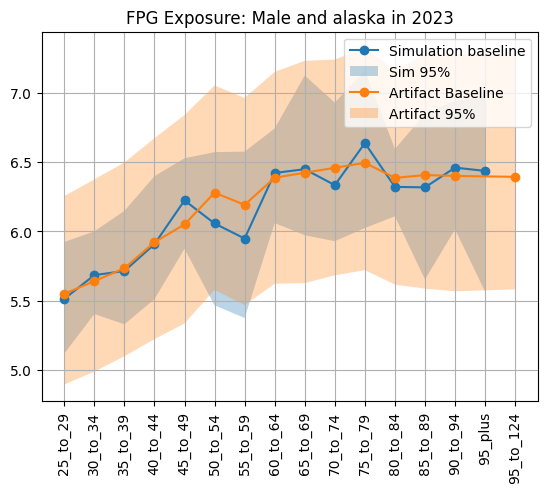

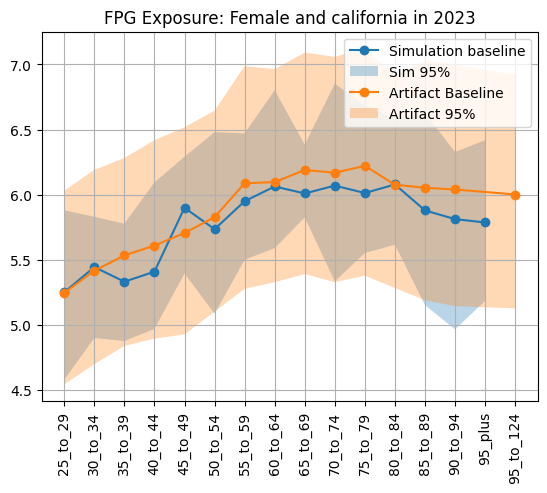

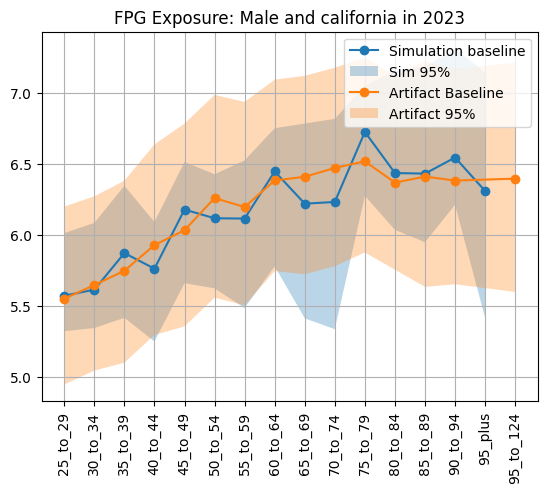

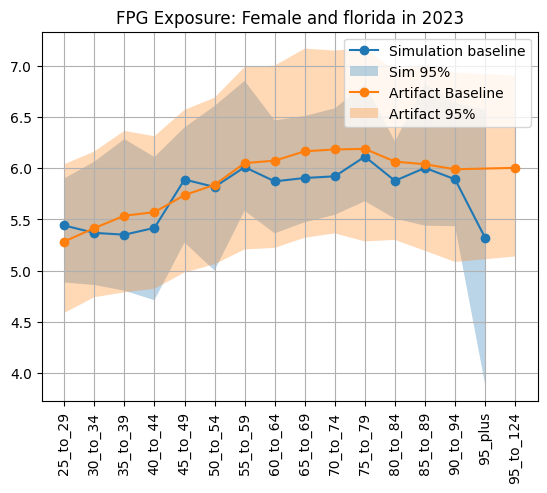

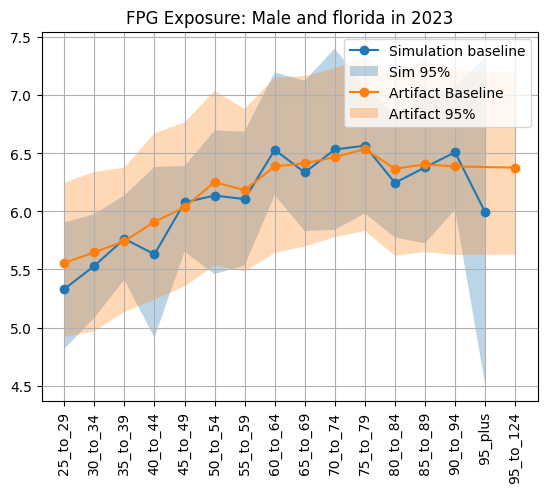

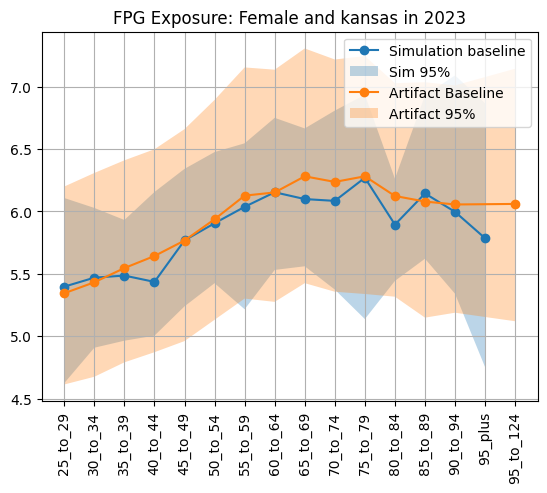

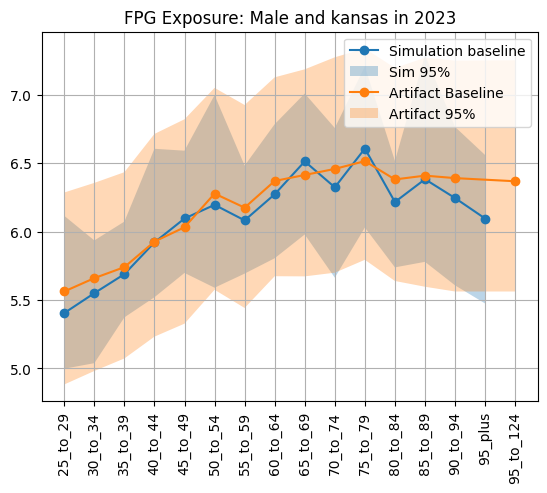

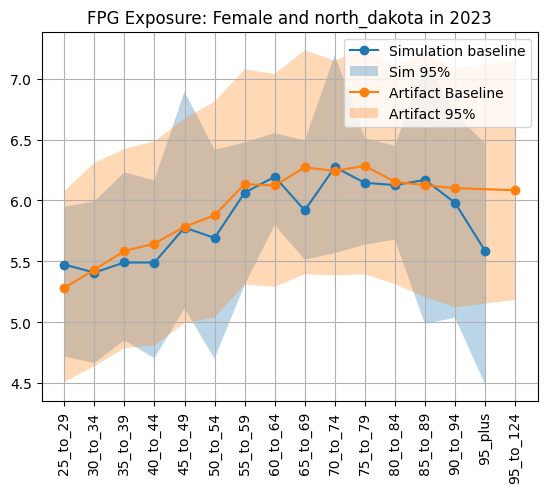

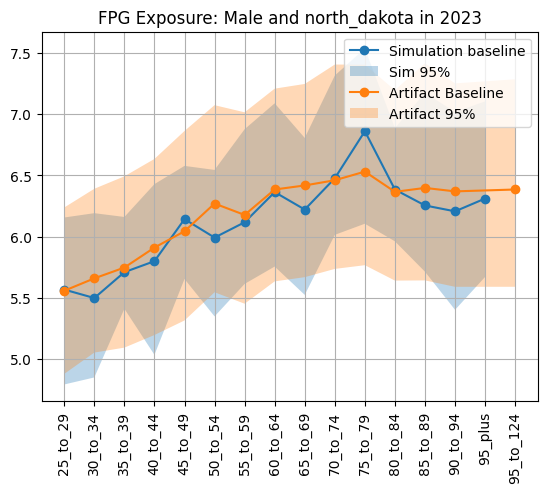

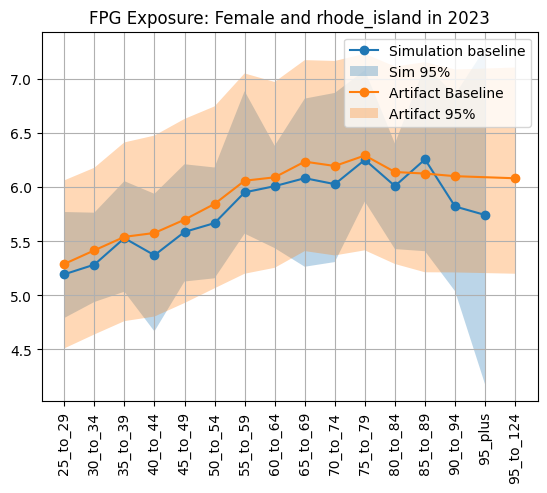

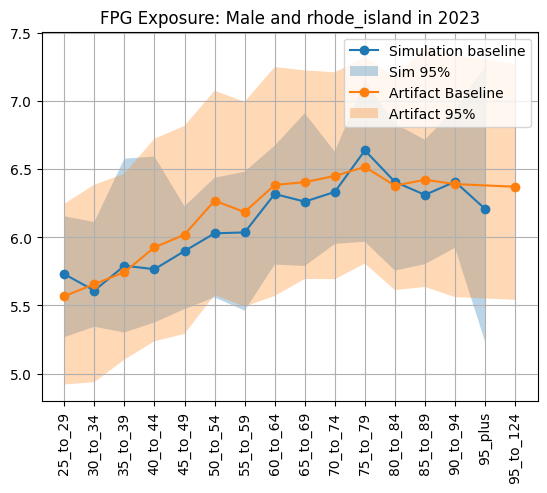

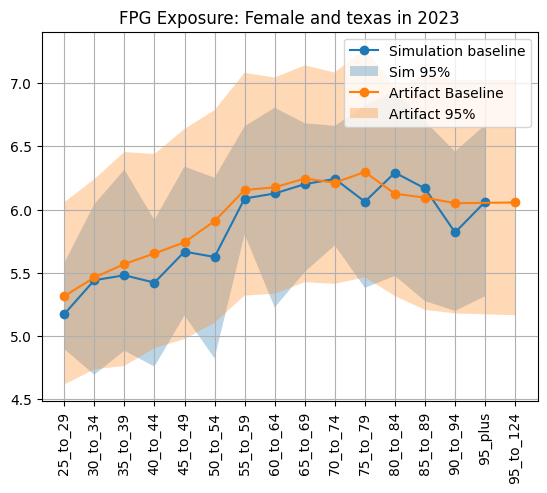

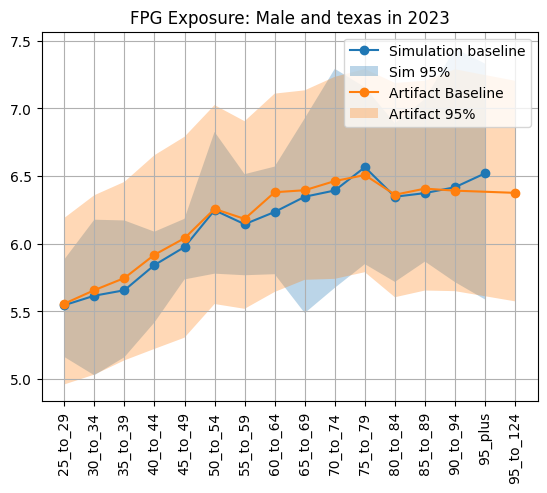

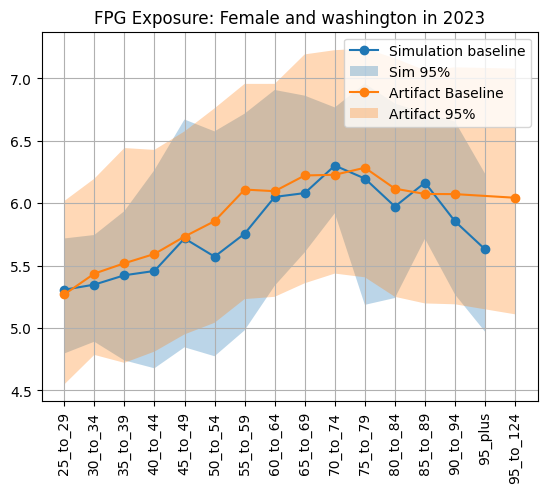

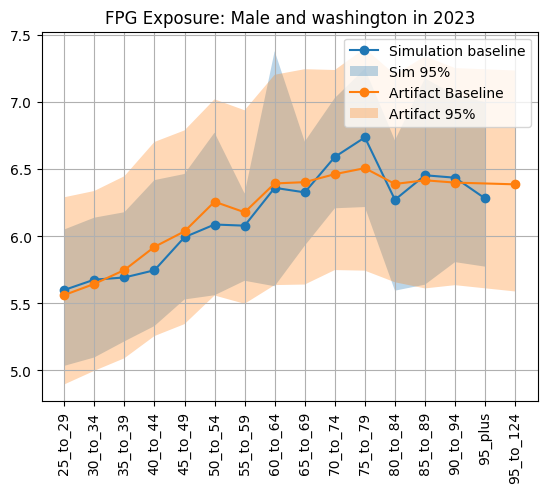

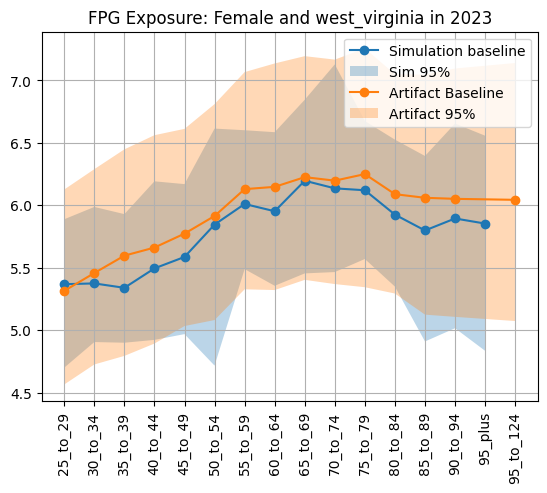

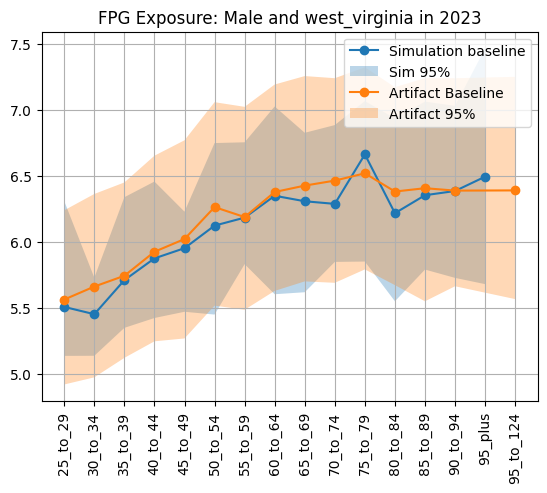

In [27]:
for location in fpg_exp_rate_summ.location.unique():
    for sex in fpg_exp_rate_summ.sex.unique():
        plt.figure() 
        subdata = fpg_exp_rate_summ.loc[(fpg_exp_rate_summ.location==location) & (fpg_exp_rate_summ.sex==sex) & (fpg_exp_rate_summ.year==2023) & (fpg_exp_rate_summ.scenario == 'baseline')]
        plt.plot(subdata['age'], subdata['mean'], marker='o')
        plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        subdata2 = fpg_art.loc[(fpg_art.location==location) & (fpg_art.sex==sex) & (fpg_art.year_end==2020)]
        plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
        plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
        plt.title(f'FPG Exposure: {sex} and {location} in 2023')
        plt.xticks(rotation=90) 
        #plt.ylim(0,100000)
        plt.grid()
        plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

Very interestingly (and almost worse overall) FPG is working great while the other 3 are looking bad